# Final Project - Dashboard Transplants in México

**Name:** Rommel Antunez Barrios 

**e-mail:** rommel.antunez6474@alumnos.udg.mx

**Name:** Wendy Stefany Escamilla Valadez 

**e-mail:** wendy.escamilla@cucei.udg.mx


## Dataset

The dataset takes the name of “Datos Abiertos de México - Trasplantes de órganos y tejidos
(2007-1er semestre 2020)”. It was obtained from El Centro Nacional de Trasplantes
(CENATRA), translated as The National Center of transplants. The dataset has the records
of patients that received organ transplant of any kind, the date of which the patient joined the
waiting list, date of transplant, time elapsed, age of the patient, type of donation and which
organ or tissue.

## General objective
This dataset is important for us to work with, because of the nature of the data, we believe
that this information could be useful for different purposes, not only educational but to inform
the people in need to have a notion of what they can expect in case of needing a procedure
of this kind.

### Modules

In [107]:

import numpy as np
import math

# from plotly
import plotly.graph_objects as go

# from pandas
import pandas as pd

# from panel
import panel as pn
import param
import plotly.express as px
pn.extension("plotly") # this is needed to use plotly in panel

# for geospatial data of Mexico
import geopandas
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.affinity import skew,rotate,scale
from shapely.geometry import Polygon

from sklearn.linear_model import LinearRegression

### Classes

In [108]:
################ CLASS TO CREATE A 2.5D MAP OF MEXICO ################
################ OBTAINED FROM https://medium.com/@gamoles/crea-un-mapa-en-proyeccion-2-5d-796ffd068e0d ################

class Map2_5D:
  def __init__(self, shapefile_path):
    # matplotlib configuration
    mpl.rc('axes.spines', top=False, right=False)
    mpl.rc('font', size=14)
    mpl.rcParams['xtick.color'] = '#bfbfbf'
    mpl.rcParams['ytick.color'] = '#bfbfbf'
    mpl.rcParams['axes.edgecolor'] = '#bfbfbf'
    mpl.rcParams['font.sans-serif'] = 'Microsoft Sans Serif'
    mpl.rcParams['font.family'] = 'sans-serif'
    mpl.rcParams['axes.titlesize'] = 20

    # get geo data
    self.mex = geopandas.read_file(shapefile_path)

    # Initial x and y coordinates
    self.x0 = -102.57634952
    self.y0 = 23.9353719
    
    # Change 'México' to 'Estado de México' in the 'name' column
    self.mex['name'] = self.mex['name'].replace('México', 'Estado de México')

    # create the 2.5 and tilted base map
    self.mex2_5 = (self.mex.sort_values(by="name")["geometry"]
             .reset_index(drop=True)
             .skew(xs=-40, ys=0, use_radians=False, origin=(self.x0, self.y0))
             .rotate(angle=33, use_radians=False, origin=(self.x0, self.y0)))

  def get_x(self, geo_df):
    """
    get_x obtains the centroids x-coordinate from the transformed map
    i.e. the x-coordinates for every state 
    """
    return (geo_df
        .centroid
        .apply(lambda p: p.x)
        .values)

  def get_y(self, geo_df):
    """
    get_y obtains the centroids y-coordinate from the transformed map
    i.e. the y-coordinates for every state
    """
    return (geo_df
        .centroid
        .apply(lambda p: p.y)
        .values)

  def scale_linear(self, A, B, cases):
    """
    scale_linear scales the number of cases to a fixed interval
    in this case the interval goes from 1 to 10.

    cases is dataset (pandas series) that contains the number of cases
    per entity.

    It return the scaled quantities, for every data point, as a 
    pandas series 
    """
    return B + (A - B) * (cases - cases.min()) / (cases.max() - cases.min())

  def return_plane_coords(self, map_):
    """
    Return the x and y coordinates of a plane, that encloses a map,
    but transformed by applying a secuence of affine transformartions
    """
    def extract_polygon(map_):
      return Polygon([(map_.total_bounds[0], map_.total_bounds[1] - 2),
              (map_.total_bounds[2] + 2, map_.total_bounds[1] - 2),
              (map_.total_bounds[2] + 2, map_.total_bounds[3] + 2),
              (map_.total_bounds[0], map_.total_bounds[3] + 2)])
    polygon = extract_polygon(map_)
    sk_tr = skew(polygon, xs=-40, ys=0, use_radians=False, origin=(self.x0, self.y0))
    rt_tr = rotate(sk_tr, angle=33, use_radians=False, origin=(self.x0, self.y0))
    return (rt_tr
        .exterior
        .coords
        .xy)

  def plot_2_5d_map(self, df):
    df = df[:32]  # Only the first 32 rows are considered
    fig, ax = plt.subplots(1, 1, figsize=(14, 14))  # figsize: size of the figure

    x = self.get_x(self.mex2_5)
    y = self.get_y(self.mex2_5)
    y2 = self.scale_linear(10, 1, df['counts'])  # Indicador ficticio: fictitious indicator

    # Plot the map
    self.mex2_5.plot(ax=ax, color="#ffffff",
             edgecolor="#bcbcbc",  # edgecolor: color of the edges
             zorder=1)  # zorder: drawing order

    # Plot orange dots
    ax.scatter(x=x,
           y=y + y2,
           color="#ff944d")

    
    ax.plot(self.return_plane_coords(self.mex2_5)[0],
        np.asarray(self.return_plane_coords(self.mex)[1]),
        color="#dddddd", zorder=1)

    for i in range(32):
      ax.plot([x[i], x[i]],
          [y[i], y[i] + y2[i]],
          color="#8c8c8c",
          zorder=1)

    # Plot the value of df["Indicador ficticio"] and df["Entidad federativa"]
    for i, (txt, entidad) in enumerate(zip(df["counts"], df["state"])):
      if txt != 0:
        ax.text(x[i], y[i] + y2[i], f'{txt:.2f}', color='black', fontsize=8, ha='center')
        ax.text(x[i], y[i] + y2[i] + 0.5, entidad, color='black', fontsize=8, ha='center')

    # Remove x and y axis legends
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Remove x and y axis scales
    ax.set_xticks([])
    ax.set_yticks([])

    return fig


### Import dataset

In [109]:
dataset = pd.read_excel(io="Trasplantes.xlsx", sheet_name="Trasplantes")
print(dataset.size)

PermissionError: [Errno 13] Permission denied: 'Trasplantes.xlsx'

In [98]:
dataset[:5]
state_dataset = dataset[['ENTIDAD FEDERATIVA TRASPLANTE', 'CODIGO ENTIDAD FEDERATIVA TRASPLANTE']].drop_duplicates().sort_values(by='ENTIDAD FEDERATIVA TRASPLANTE').reset_index(drop=True)
state_dataset.columns = ['state', 'state_code']
state_dataset

,state,state_code
0,AGUASCALIENTES,1.0
1,BAJA CALIFORNIA,2.0
2,BAJA CALIFORNIA SUR,3.0
3,CAMPECHE,4.0
4,CHIAPAS,7.0
5,CHIHUAHUA,8.0
6,CIUDAD DE MÉXICO,9.0
7,COAHUILA,5.0
8,COLIMA,6.0
9,DURANGO,10.0


### Create Dashboard

c:\Users\wendy\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning:

mexican-states/mexican-states.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.

C:\Users\wendy\AppData\Local\Temp\ipykernel_14216\1403556320.py:38: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\wendy\AppData\Local\Temp\ipykernel_14216\1403556320.py:48: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




BokehModel(combine_events=True, render_bundle={'docs_json': {'6d822e4d-f045-446f-a9b9-05e3de611b82': {'version…

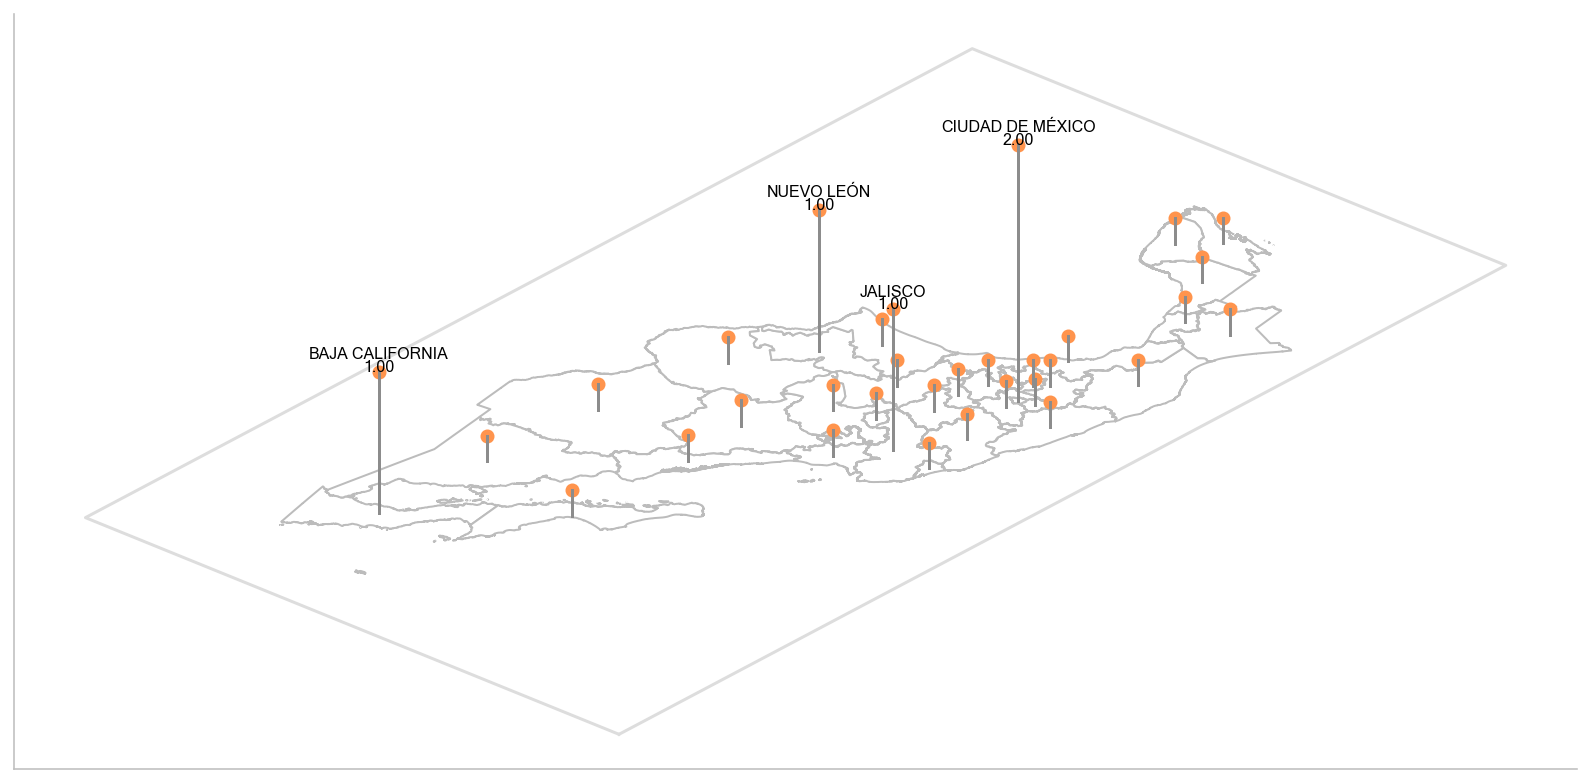

UnknownReferenceError: can't resolve reference '0c05ef0f-f732-40dd-b0b2-aac68d08ecc3'

In [116]:


# BEGIN: Panel Dashboard

# Define widgets
gender_filter = pn.widgets.RadioButtonGroup(name='Gender', options=['Male', 'Female'], value='Female')
organ_filter = pn.widgets.RadioButtonGroup(name='Organ', options=['Heart', 'Kidney', 'Liver', 'Cornea'], value='Kidney')
age_filter = pn.widgets.IntInput(name='Age', value=10, start=0, end=120)
date_filter = pn.widgets.IntInput(name='Date Range (days)', start=0, end=31, value=0)

state_filter = pn.widgets.Select(name='State', options=list(state_dataset['state']))

plot_type_filter = pn.widgets.RadioButtonGroup(name='Plot Type', options=['Map', 'Linear Regression', 'Histogram'], value='Map')

def translate_organ(organ):
    if organ == 'Heart':
        return 'CORAZÓN'
    elif organ == 'Kidney':
        return 'RIÑÓN'
    elif organ == 'Liver':
        return 'HÍGADO'
    elif organ == 'Cornea':
        return 'CÓRNEA'
    else:
        return None
    
def translate_gender(gender):
    if gender == 'Male':
        return 'MASCULINO'
    elif gender == 'Female':
        return 'FEMENINO'
    else:
        return None

# Create plotting logic
@param.depends(organ_filter, gender_filter, state_filter, age_filter, date_filter, plot_type_filter)
def view(organ_filter, gender_filter, state_filter, age_filter, date_filter, plot_type_filter):
    
    filtered_data = dataset[(dataset['ORGANO'] == translate_organ(organ_filter)) & (dataset['SEXO'] == translate_gender(gender_filter))]
    
    filtered_data_by_state = filtered_data[filtered_data['ENTIDAD FEDERATIVA TRASPLANTE'] == state_filter]
    filtered_data_by_age = filtered_data[filtered_data['EDAD AL TRASPLANTE ANIOS'] == age_filter]
    filtered_data_by_wait_time = filtered_data[filtered_data['ESPERA'] == date_filter]
    
    # Get a count of registers from filtered_data grouped by 'ENTIDAD FEDERATIVA TRASPLANTE' and 'ESPERA'
    grouped_data_for_map = filtered_data.merge(filtered_data_by_age).merge(filtered_data_by_wait_time).groupby('ENTIDAD FEDERATIVA TRASPLANTE').size().reset_index(name='counts')
    
    # Get a count of registers from filtered_data grouped by 'ENTIDAD FEDERATIVA TRASPLANTE'
    grouped_data_for_regression = filtered_data.merge(filtered_data_by_state)

    # Get a count of registers from filtered_data grouped by 'ENTIDAD FEDERATIVA TRASPLANTE'
    grouped_data_for_histogram = filtered_data.merge(filtered_data_by_state).merge(filtered_data_by_age)
    
    state_counts = state_dataset.copy()
    state_counts['counts'] = 0

    for index, row in grouped_data_for_map.iterrows():
        state_counts.loc[state_counts['state'] == row['ENTIDAD FEDERATIVA TRASPLANTE'], 'counts'] = row['counts']
    fig2 = go.Figure()
    if plot_type_filter == 'Map':
        # Placeholder for map plot
        map = Map2_5D("mexican-states/mexican-states.shp").plot_2_5d_map(state_counts)
        return pn.pane.Matplotlib(map, dpi=144, width=800, height=800)

    elif plot_type_filter == 'Linear Regression':
        X = grouped_data_for_regression[['ESPERA']] 
        y = grouped_data_for_regression['EDAD AL TRASPLANTE ANIOS']

        if not X.empty and not y.empty:
            model = LinearRegression()
            model.fit(X, y)

            y_pred = model.predict(X)

            fig2 = px.scatter(x=X.squeeze(), y=y, title='Regresión Lineal', labels={'x': 'Espera', 'y': 'Edad'})
            fig2.add_traces(go.Scatter(x=X.squeeze(), y=y_pred, mode='lines', name='Línea de Regresión', line=dict(color='red')))

        else:
            fig2 = go.Figure().add_annotation(text="No hay datos suficientes para la regresión", showarrow=False)
    elif plot_type_filter == 'Histogram':
        # Placeholder for histogram plot
        fig2 = px.histogram(grouped_data_for_histogram, x='ESPERA',nbins=30, title='Histogram wait time')

    return pn.pane.Plotly(fig2, height=400, width=500)

column1 = pn.Column(
    organ_filter,
    gender_filter, 
    state_filter,
    age_filter, 
    date_filter, 
    plot_type_filter
)

column2 = view

# Layout the dashboard
layout = pn.Row(column1, column2)

layout.servable()
# END: Panel Dashboard